# Named Entities Recognition with Spacy for Wines

### What is the task of annotation?

(from https://spacy.io/universe/project/video-spacys-ner-model, Matthew Honnibal, creator of Spacy)

Words defined in term of words defined in other words...  Or, better:

*"Trying to learn Chinese by reading in Chinese to Chinese dictionary"*

What's so hard about Named Entity Recognition??

* Structured prediction $\longrightarrow$ super interesting!

* Knowledge intensive $\longrightarrow$ pretty cool?

* Mix of easy and hard cases $\longrightarrow$ super frustrating..

The problem is that even if you have a super powerful algorithm, it will maybe perform quite the same as an easy one.

---

### How does spacy solve named entities recognition tasks? (Summary)

**Word embedding**: Each word is embedded in a representation of this type: ( norm | prefix | suffix | shape ).<br> The sentence/text embedded like this for each word is then passed to an hash function which outputs a 128 units vector for each word. This embedding for the single word is then passed to a multi-layered perceptron with one hidden layer and the Maxout unit (layer where the activation function is the max of the inputs), which outputs a vector of the same length.

<img src="Images/one.png" alt="drawing" style="width:450px;"/>

Then, to embed the neighboring words, Spacy uses **Convolutional Neural Networks**.<br>
Basically, it recalculates the words vector based on the context:<br>
For each word creates a **trigram** (with neighbors) and then feeds it into the CNN, passes it to a multi-layered perceptron and comes back to the original words size. With this process we relearn what this word means on its neighbors.

In the next layer you take informations from two words on each side, and so on. There is a decaying impact on the informaton if it comes from neighbors which are more far away, because the information it is filtered by the nearer neighbors.


<img src="Images/two.png" alt="drawing" style="width:450px;"/>


Then the vectors for each word (which compose a matrix) are passed to an **attenton layer**:
it is a kind of neural network layer (used a lot in translation tasks), which selects only the piece of the phrase needed to work on the current word.
which sumamrizes this matrix to a single vector.

<img src="Images/four.png" alt="drawing" style="width:450px;"/>

As a "prediction" layer we have a simple multi-layered perceptron.

In [1]:
import spacy
from spacy.util import decaying
from spacy.lang.it.examples import sentences
from spacy.gold import GoldParse
from spacy.scorer import Scorer

import matplotlib.pyplot as plt

import os
import re

# python3 -m spacy download en
spacy.load("en")
# python3 -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md') #lg blocca tutto, 1 Gb di modello

import numpy as np
import pandas as pd
import pickle

#from fuzzywuzzy import process
#from fuzzywuzzy import fuzz
#from fuzzysearch import find_near_matches

import json
import copy
from itertools import islice

import nltk.stem as stem

Some utility functions:

In [2]:
def save_obj(obj, name):
    with open("saved_things/" + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open("saved_things/" + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

## Files Loading

In [3]:
# GRAPES
with open('knowledge/grapes.json') as json_data:
    grapes = json.load(json_data)
    json_data.close()
    grapes = grapes['grapes']

grapes = [i.lower() for i in grapes]
gr = [" " + grape + " " for grape in grapes]


# WINE KIND
with open('knowledge/kind.json') as json_data:
    kind = json.load(json_data)
    json_data.close()
    kind = kind['kind']

kind = [i.lower() for i in kind]
kind = [" " + i.lower()+" " for i in kind]


# ITA WINENAME
with open('knowledge/appellations-it.json') as json_data:
    winename = json.load(json_data)
    json_data.close()
    winename = winename['appellations']
    
winename = [i.lower() for i in winename]


# USA WINENAME
winename_usa_tmp = pd.read_csv('knowledge/appellations-usa.csv')
winename_usa_tmp.iloc[:,0] = winename_usa_tmp.iloc[:,0] .map(lambda x: x.replace(' AVA',''))

winename_usa = list(winename_usa_tmp.iloc[:,0])
winename_usa = [x.lower() for x in winename_usa]

In [4]:
#### LOADING LIST OF JSONS WITH OCR FROM PYTHON

directory = "saved_things/"

ocrs_dict = {}
with open(directory + 'ocrs_dictionary_improved.json' ) as json_data:
    ocrs_dict = json.load(json_data)
    json_data.close()

# taking a fraction of ocrs to create first part of train set
ocrs_dict_slice = {}
INDICE = int(len(ocrs_dict)/6*5)
for i in take(INDICE, ocrs_dict.items()):
    ocrs_dict_slice[i[0]] = i[1]

# taking remaining ocrs as test set
test = {}
for i in take(len(ocrs_dict), ocrs_dict.items()):
    if int(i[0]) > INDICE:
        test[i[0]] = i[1]
        
        
# ================================================================        
# ================================================================


#### LOADING REVIEWS

with open("knowledge/" + 'winemag-data-130k-v2.json') as json_data:
    reviews = json.load(json_data)
    json_data.close()
    
# indexing reviews correctly to append them to ocrs dictionary
reviews_dict = {}
tmp = INDICE + 2
for i in reviews:
    reviews_dict[tmp] = i['description']
    tmp += 1
#print(len(reviews_dict))

# taking first 1000 reviews
tmp = {}
for i in take(1000, reviews_dict.items()): 
    tmp['{}'.format(i[0])] = i[1]

reviews_dict = tmp



# PUTTING WINE OCR AND SOME REVIEWS TOGHETER TO CREATE A BIGGER TRAIN LIST 
train = {**ocrs_dict_slice, **reviews_dict}
len(train)

1435

#### LOADING LIST OF 600 JSONS WITH OCR FROM GOOGLE
directory = "/home/nicole/Data Science/Software dev/esteco_project/ocr_google/"

jsons_google = {}
for filename in os.listdir(directory):
    tmp = re.findall('\d+',"{}".format(filename))[0]
    with open(directory + "{}".format(filename) ) as json_data:
        d = json.load(json_data)
        json_data.close()
        jsons_google[tmp] = d[0]['description'].lower()
        
jsons = jsons_google

### Lists of Label for entities

In [5]:
ORG = ["Winery", "Company", "Companies", "Cellar"]

loc = ["Mountain", "River", "Lake", "Lakes", "Earth", "Trees", "Castle", "Terrain", "Garden"]

places = ["Missouri", "City", 'san benito county', "new york", "COLCHAGUA VALLEY", "san luis obispo",\
          "Italy", "New Zealand", "St. Louis County", "Columbia Valley", "Carolina", "Spain", "Italia", \
          "France", "Slovenija", "Australia", "Chile", "España", "USA", "Canada", "Oregon", "California",\
          "Europe", "NAPA", "Portland", "yorkville", "Santa Clara County", "monterey county", "Oakville",\
          "Walla walla", "St Helena", "santa barbara county", "Saint Helena", "New Mexico", "Manhasset"]

fruit = ["Honey", "Fruit", "Fruits", "Strawberry", "Raspberry", "Apple", "Citrus", "Vanilla", "Pineapple", "Pear", "Mint", "Plum", "Blackberry", "Cherry", "Melon", "Peach", "Lemon", "Lime", "Mango"]

product = ["Bottle", "Beverages", " Car ", "Cheese", "Meat"]

year = list(map(str, range(1600, 2019)))
year = [" "+str(i)+" " for i in year]

alcohol = np.arange(10, 18, 0.1).round(2)
alcohol = [str(i)+"%" for i in alcohol]

ORG = [x.lower() for x in ORG]
loc = [x.lower() for x in loc]
places = [x.lower() for x in places]
fruit = [x.lower() for x in fruit]
product = [x.lower() for x in product]

with open("knowledge/list_aromas.txt", "rb") as fp:
    aromas = pickle.load(fp)
"""aromas = aromas + ['citrus', 'black fruit', 'red fruit', 'spices', 'dried fruit','dried sage', 'floral', 'cork', \
                   'tropical fruit', 'juicy', 'blackberry', 'berry', 'savory herb', 'dark plum', 'herbal',\
                   'candied berry', 'spice', 'fruity', 'fresh', 'spicy','black cherry', 'espresso', 'buttercream',\
                   'mineral','baked plum','acidity','pepper','clove','red fruit','berry','white flower','licorice', \
                   'coffee beans', 'yellow flower', 'yellow fruit', 'yellow-fruit','berry fruit', 'berry fruits',\
                   'tannins', 'red berry fruits'] + fruit"""
    
taste = ["Semi-Dry", "SemiDry", "Semi Dry", "Medium-Dry", "MediumDry",  "Medium Dry", "Dry", \
         "Semi-Sweet", "SemiSweet", "Semi Sweet", "Sweet", "Medium-Sweet", "MediumSweet", "Medium Sweet", \
         "Full-Bodied", "FullBodied", "Full Bodied", "Medium-Bodied", "MediumBodied", "Medium Bodied", \
         "Crisp", "Balance", 'Sparkling', 'rough', 'tannic', 'tannins', 'smooth']
taste = [x.lower() for x in taste]

vineyards = ['gimelli vineyards', 'Boenker Hill Vineyard', 'edna valley vineyard', 'laetitia vineyard', \
             'Lockwood Vineyards', 'Skyfall Vineyard', 'sonoma coast vineyards', 'balletto vineyards', \
             'Becker Vineyards', 'mount baker vineyards', 'guerra vineyards', 'camelot vineyard', 'pedregal vineyard', \
             'chalone vineyard', 'adastra vineyard', 'sangiovese vineyards', 'weir vineyard', \
             'spring hill vineyards', 'adelsheim vineyard', 'gunsalus vineyard', 'leaping horse vineyards', \
             'reed vineyard', 'ADIRONDACK WINERY', 'Chapelle Winery']
vineyards = [x.lower() for x in vineyards]

#food = [seafood, pot, chicken, ssh, creamy sauce dishes,\ntight salads or sandwiches and song cheeses meat dish]
##['toasty', 'creamy', 'loamy', 'minerally', 'minerality', 'toasted', 'bodied', 'buttered toast'] acidity

## Functions to create the labeled list of sentences

In [6]:
def sentence_setup(sent):
    
    '''preparing, for each sentence, a tuple with 
    the sentence and the list of entities (empty)'''
    
    tupla = (sent.lower(), {'entities': [] })
    return tupla
# ===============================================================


def tag(label, list_of_words, tupla):
    
    '''function to tag a single sentence searching for words and labeling them, 
    assuring to not overlabel entities which are already labeled'''
    
    sent, entities = tupla
    #regex = re.compile('[^a-zA-Z]')
    st = stem.RegexpStemmer('ing$|s$|y$|ly$|ed$', min=4)
    
    for word in list_of_words:
        if word in sent:
            all_recurrencies_word = re.finditer(word, sent)
            
            # tagging all recurrency of the word(\words) in the sentence
            for i, word_recurrence in enumerate(all_recurrencies_word):
                if all(ent[0][0] != word_recurrence.start() for ent in entities['entities']):
                    new_ent = [(word_recurrence.start(), word_recurrence.end(), label, word)]
                    entities['entities'].append(new_ent)
                                    
    return(tupla)
# ==================================================================
    
    
# ============ MAIN FUNCTION =============

def label_tagging(sentences, dict_of_tags):
    
    '''main function which loops over the sentences 
    dictionary to tag the entities into tuples'''

    tuples = []
    for key, sent in sentences.items():
        tupla = sentence_setup(sent)
        for key, val in dict_of_tags.items():
            tupla = tag(key, val, tupla)
        tuples.append(tupla)
            
    return(tuples)

## Creating labeled list of sentences

In [7]:
dict_of_tags = {"VINE": grapes, "LOC": loc, "WINENAME": winename + winename_usa, "GPE": places, \
                "ORG": ORG,  "DATE": year, "KIND": kind, "AROMA": aromas, "TASTE": taste, \
                "VINEYARD": vineyards}

#### Launch labeling and save, or load

In [6]:
labeled_train = label_tagging(train, dict_of_tags)
labeled_test = label_tagging(test, dict_of_tags)

NameError: name 'label_tagging' is not defined

In [ ]:
#save_obj(labeled_train, "labeled_train")
#save_obj(labeled_test, "labeled_test")
#save_obj(lab, "labeled_reviews")

In [305]:
#labeled_train = load_obj("labeled_train")
#labeled_test = load_obj("labeled_test")
#labeled_reviews = load_obj("labeled_reviews")

# Training model

In [9]:
from __future__ import unicode_literals, print_function

import plac
import random
from pathlib import Path
from spacy.util import minibatch, compounding
# ============================================================================================= 



def get_batches(train_data, model_type):
    max_batch_sizes = {'tagger': 32, 'parser': 16, 'ner': 16, 'textcat': 64}
    max_batch_size = max_batch_sizes[model_type]
    if len(train_data) < 1000:
        max_batch_size /= 2
    if len(train_data) < 500:
        max_batch_size /= 2
    batch_size = compounding(1, max_batch_size, 1.001)
    batches = minibatch(train_data, size=batch_size)

    return batches
# ============================================================================================= 



def main(LABEL, TRAIN_DATA, drop, model=None, new_model_name='wines', output_dir=None, n_iter=10):
    """Set up the pipeline and entity recognizer, and train the new entity."""
    if model is not None:
        nlp = spacy.load(model) #  load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en')  # create blank Language class
        print("Created blank 'en' model")
    # Add entity recognizer to model if it's not in the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    # otherwise, get it, so we can add labels to it
    else:
        ner = nlp.get_pipe('ner')

    if (isinstance(LABEL, list)):
        for L in LABEL:
            ner.add_label(L)
    else: 
        ner.add_label(LABEL)
    if model is None:
        optimizer = nlp.begin_training()
    else:
        #'begin_training' initializes the models, so it'll zero out existing entity types.
        optimizer = nlp.entity.create_optimizer()

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    losses_list = []
    with nlp.disable_pipes(*other_pipes):  # only train NER
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}
            # batch up the examples using spaCy's minibatch
            # batches = get_batches(TRAIN_DATA, "ner")
            dropout = decaying(0.7, 0.2, 1e-1)
            batches = minibatch(TRAIN_DATA, size=compounding(50., 500., 30.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                drop = next(dropout)
                #print(drop)
                nlp.update(texts, annotations, sgd=optimizer, drop=drop,
                           losses=losses)
            losses_list.append(losses['ner'])
            print('iteration ', itn, ', Losses', losses)

    # test the trained model
    test_text = test['451']
    doc = nlp(test_text)
    print("Entities in '%s'" % test_text)
    print("==================")
    for ent in doc.ents:
        print(ent.label_, ent.text)
        

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.meta['name'] = new_model_name  # rename model
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        """print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        for ent in doc2.ents:
            print(ent.label_, ent.text)"""
    return losses_list

#### Start model training
(Do not run it if you're not sure and brave)

In [ ]:
# OLD PC!!!
L = ["VINE", "KIND", "AROMA", "WINENAME", "ALCOHOL", "TASTE", "VINEYARD"]

loss = main(LABEL = L, TRAIN_DATA = labeled_train, drop = 0.35, model = 'en_core_web_md', n_iter = 5, output_dir = "output_model_ocr_google")

Loaded model 'en_core_web_md'
iteration  0 , Losses {'ner': 167685.22723388672}
iteration  1 , Losses {'ner': 183977.1552886963}


In [104]:
#L = ["VINE", "KIND", "AROMA", "WINENAME", "ALCOHOL", "TASTE", "VINEYARD"]

#loss = main(LABEL = L, TRAIN_DATA = labeled_train, drop = 0.35, model = 'en_core_web_md', n_iter = 25, output_dir = "output_model_ocr_google")

Loaded model 'en_core_web_lg'
iteration  0 , Losses {'ner': 0.032081051766908786}
iteration  1 , Losses {'ner': 0.01871299426056794}
iteration  2 , Losses {'ner': 0.02453815328794917}
iteration  3 , Losses {'ner': 0.028435918107788893}
iteration  4 , Losses {'ner': 0.017151243498801705}
iteration  5 , Losses {'ner': 0.0170900036087005}
iteration  6 , Losses {'ner': 0.016519607813393122}
iteration  7 , Losses {'ner': 0.01316878324733084}
iteration  8 , Losses {'ner': 0.01531941621851729}
iteration  9 , Losses {'ner': 0.015748691503439716}
iteration  10 , Losses {'ner': 0.015846964844058675}
iteration  11 , Losses {'ner': 0.012845607702033135}
iteration  12 , Losses {'ner': 0.019628980061497714}
iteration  13 , Losses {'ner': 0.020614732658941648}
iteration  14 , Losses {'ner': 0.02374336332616167}
iteration  15 , Losses {'ner': 0.014534122405633454}
iteration  16 , Losses {'ner': 0.01778060311784202}
iteration  17 , Losses {'ner': 0.016252473854649452}
iteration  18 , Losses {'ner': 0.0

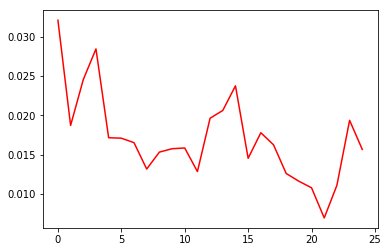

In [106]:
x = list(range(0, len(loss)))
plt.plot(x, loss, 'r')
plt.show()

# Testing saved model

### Evaluation Metrics

In [7]:
nlp = spacy.load("output_model_ocr_google")

In [114]:
def evaluate(nlp, examples):
    scorer = Scorer()
    for input_, annot in examples:
        text_entities = []
        for entity in annot.get('entities'):
            #if ent in entity:
            text_entities.append(entity)
        doc_gold_text = nlp.make_doc(input_)
        gold = GoldParse(doc_gold_text, entities=text_entities)
        pred_value = nlp(input_)
        scorer.score(pred_value, gold)
    return scorer.scores


results = evaluate(nlp, labeled_test[0:4])
print(results)

{'uas': 0.0, 'las': 0.0, 'ents_p': 0.0, 'ents_r': 0.0, 'ents_f': 0.0, 'tags_acc': 0.0, 'token_acc': 100.0}


In [11]:
file = test['452']
print(file, "\n\n")
doc = nlp(file)
for ent in doc.ents:
    print(ent.text, ent.label_)

= STE
CHAPELLE
CHARDONNAY

Overlooking the farms and orchards of the Snake
River Valley are Ste. Chapelle Winery’s premium
vineyards. Since 1976 we’ve recognized that cool
winters, hot summers, volcanic ash soils and the
vineyards’ lofty elevations lend to incredible flavor
and balance. These distinct characteristics can be
found in our refreshing Chardonnay. Enjoy beautiful
pineapple, pear and toasty oak notes with grilled
seafood, roast chicken or mild cheeses.

 

PRODUCED & BOTTLED BY
STE. CHAPELLE, CALDWELL, IDAHO

GOVERNMENT WARNING: (1) ACCORDING TO
THE SURGEON GENERAL, WOMEN SHOULD
NOT DRINK ALCOHOLIC BEVERAGES DURING
PREGNANCY BECAUSE OF THE RISK OF BIRTH
DEFECTS. (2) CONSUMPTION OF ALCOHOLIC
BEVERAGES IMPAIRS YOUR ABILITY TO DRIVE
A CAR OR OPERATE MACHINERY, AND MAY
CAUSE HEALTH PROBLEMS.

750mL CONTAINS SULFITES ° 


CHARDONNAY VINE
River LOC
Winery ORG
balance TASTE
Chardonnay VINE
pineapple AROMA
pear AROMA
oak AROMA


In [15]:
def precision(tp, fp):
    return tp / (tp + fp)
    
def recall(tp, fn):
    return tp / (tp + fn)

def fbeta_score(beta, tp, fn, fp): 
    return  ( (1+beta**2) * tp ) / ( (1 + beta**2) * tp + beta**2 * fn + fp ) 

In [97]:
tp_list = []; fp_list = []; f_score = []; fn_list = []; weights = []


for num, entry in enumerate(labeled_test[0:1]):
    file = labeled_test[num]

    exact = []
    for i in file[1]['entities']:
        exact.append([i[2], file[0][i[0]:i[1]].lower()])

    doc2 = nlp(file[0])
    outcome = []
    for ent in doc2.ents:
        outcome.append([ent.label_, ent.text.lower()])
    #print("exact:", exact, "\n"); print("outcome: " ,outcome)

    tp = 0
    L = len(exact)
    if L != 0:
        for i in exact:
            for j in outcome:
                if i[0] == j[0] and i[1] in j[1]: # in or == ??
                    tp += 1
                    outcome.remove(j)
        fn = len(exact) - tp
        fp = len(outcome)
        fp_list.append(fp)
        tp_list.append(tp)
        fn_list.append(fn)
        f_score.append(fbeta_score(1, tp, fn, fp))
        weights.append(L)

        

tp = np.mean(tp_list)
fn = np.mean(fn_list)
fp = np.mean(fp_list)
beta = 1
print("F-{}".format(beta), "SCORE:", fbeta_score(beta, tp, fn, fp))
print(np.mean(f_score))
print(f_score)
len(f_score)
len(weights)
np.average(f_score, weights = weights)

F-1 SCORE: 0.9230769230769231
0.9230769230769231
[0.9230769230769231]


0.9230769230769231

# Old things 

### UNUSED 

def word_in_list(lista, sentence, label, dictionar):
    #st = RegexpStemmer('ing$|s$|y$|ly$|ed$', min=4)
    found_words = []
    for word in lista:
        word = word.lower()
        if (label == 'AROMA'):
            """if (st.stem(word) in sentence.lower()):
                print("word: ", word, "stem:", st.stem(word))
            #if (word in sentence.lower()):
                dictionar['entities'].append( (sentence.lower().index(st.stem(word)), sentence.lower().index(st.stem(word)) + len(word), label ))
                if word not in found_words:
                    found_words.append(word)"""
        #else:
        if (word in sentence.lower()):
            dictionar['entities'].append( (sentence.lower().index(word), sentence.lower().index(word) + len(word), label, word ))
            if word not in found_words:
                found_words.append(word)
            
    return (found_words, dictionar)
#### ============================================================================================= 



def entity_search(list_name, lista, entities, sentence, label, dictionar):
    
    found_words = []
    for ent in entities:
        for word in lista:
            if (ent.text.lower() == word):
                dictionar['entities'].append(  ( ent.start_char, ent.end_char, label))
                if word not in found_words:
                    found_words.append(word)

    return (found_words, dictionar)
#### ============================================================================================= 



def percent_check(entities, sentence, dictionar):
    for ent in entities:
        if (ent.label_ == "PERCENT"):
            for word in ent.text.split():
                if ("%" in word and re.search(r'\d', word)):
                    if (float(re.sub('[^0-9.]', '', word)) > 6 and float(re.sub('[^0-9.]', '', word)) < 15):
                        #num = re.sub('[^0-9.]', '', word)
                        #if ( float(num) > 6 and  float(num) < 16):
                         dictionar['entities'].append(  ( ent.start_char, ent.end_char, "ALCOHOL"))# (  (sent.string.strip(), {"entities": [( ent.start_char, ent.end_char, "ALCOHOL")]})  )
    return dictionar
#### ============================================================================================= 



def entity_check(doc):
    print("TEXT:")
    print(doc)
    print("ENTITIES:")
    for ent in doc.ents:
        print(ent.text, ent.label_)
    print("NOUN CHUNKS")
    for chunk in doc.noun_chunks:
        print("text: ", chunk.text, ", root:", chunk.root.text, ", root dependency:", chunk.root.dep_, \
              ", root head text: ", chunk.root.head.text)
#### ============================================================================================= 



def entity_site(entities, sentence, dictionar):
    for ent in entities:
        if ("www" in ent.text.lower() or "www" in ent.text.lower().replace(" ", "") or ".com" in ent.text.lower()):
            dictionar['entities'].append(  ( ent.start_char, ent.end_char, "SITE"))

def fuzzy_extract(qs, ls, threshold):
    '''fuzzy matches 'qs' in 'ls' and returns list of 
    tuples of (word,index)
    '''
    for word, _ in process.extractBests(qs, (ls,), score_cutoff=threshold):
        #print('word {}'.format(word))
        for match in find_near_matches(qs, word, max_l_dist=1):
            match = word[match.start:match.end]
            #print('match {}'.format(match))
            index_start = ls.find(match)
            index_end = ls.find(match)+len(match)
            yield (match, index_start, index_end)
#### =============================================================================================             
    
    
    
def fuzzy_extract_on_list(lista, sentence, threshold, dictionar, label):
    
    found_words = []
    for query in lista:
        if (len(query) > 4):
            for match, index_start, index_end in fuzzy_extract(" " + query.lower() + " ", sentence.lower(), threshold):
                dictionar['entities'].append(  ( index_start, index_end, label))
                #print("match with: ", query, "and ", match)
                if match not in found_words:
                    found_words.append(match)
                #print('for {}, match: {}\nindex_start: {}\nindex_end: {}, sentence: {}\n'.format(query.lower(), match, index_start, index_end, sentence))
    return (found_words, dictionar)

_="""large_string = jsons['181'].lower()
query_string = "Pinot Noir".lower()
queries = ["Pinot Noir", "Mountain"]

for query in queries:
    print("=====>",query)
    for match, index_start, index_end in fuzzy_extract(query.lower(), large_string, 50):
        print('for {}, match: {}\nindex_start: {}\nindex_end: {}'.format(query, match, index_start, index_end))"""

### UNUSED
def labeling_function(jsons):

    prova_train = []

    num = 1
    #entities_found_total = 0
    for key, value in jsons.items():
        if (int(key) < 130571): # TOT 130571
            if (int(key)%50 == 0): print(num, "============ key: ", key , "============")
            num += 1
            wine_found = False
            entity_added = 0

            dic = {"entities": []}

            sentence = value
            tmp = nlp(sentence)


            for list_name in list_of_entites:
                #print("======== ", list_name, "========")
                list_tmp = copy.deepcopy(list_of_entites[list_name])

                # ENTRO NELLE ENTITA DELLA FRASE GIA TROVATE E CONTROLLO SE POSSO RECUPERARE QUALCOSA
                """found_words, dic = entity_search(list_name, list_tmp, tmp.ents, sentence, list_name, dic)
                #print("entity found words:", found_words)
                if (list_name =="VINE" and found_words != []): wine_found = True
                if (list_name == "TASTE"):
                    for word in found_words:
                        for full_word in list_tmp:
                            if (word in full_word): list_tmp.remove(full_word)
                else:
                    [list_tmp.remove(i) for i in found_words]"""

                # SE NELLE ENTITA NON TROVO NIENTE, CERCO NELLA FRASE QUALCHE PAROLA IN MODO LINEARE
                found_words, dic = word_in_list(list_tmp, sentence, list_name, dic)
                if (list_name =="VINE" and found_words != []): wine_found = True
                #print("linearly found words:", found_words)
                if (list_name == "TASTE"):
                    for word in found_words:
                        for full_word in list_tmp:
                            if (word in full_word): list_tmp.remove(full_word)
                else:
                    [list_tmp.remove(i) for i in found_words]


                #if (list_name == "VINE" and wine_found == False):
                #    found_words, dic = fuzzy_extract_on_list(list_tmp, sentence, 75, dic, list_name)
                    #[list_tmp.remove(i) for i in found_words]

            # SITE AND ALOCHOL LEVEL A PART 
            entity_site(tmp.ents, sentence, dic) 
            word_in_list(alcohol, sentence, "ALCOHOL", dic)
            del list_tmp

            # append results
            prova_train.append( (sentence, dic))

    return prova_train